# Definitions

## Import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import yt

import athena_read as ar

# import seaborn as sns

plt.style.use('../plot_scripts/plot_style.mplstyle')

import para_scan as ps
import v_turb as vt
# import tgrow as tg

/afs/mpa/data/hitesh/envs/athenaenv/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


## Class hst_data definitions

In [2]:
class hst_data:

    def __init__(self, fn, ncells, MHD_flag=False, cool_flag=False):

        """Read hst and return structured numpy dict.
        Keyword Arguments:
        fn -- 
        """

        hdr = []
        with open(fn, 'r') as fp:
            while True:
                l = fp.readline()
                if l[0] != '#':
                    raise Exception("No header in %s found!" %(fn))
                if '[1]' in l:
                    hdr = [i.split("=")[1].strip() for i in l[1:].split("[") if ']' in i]
                    break

        r = np.loadtxt(fn, dtype={'names' : hdr, 'formats' : len(hdr) * (float,)})

        self.dict = r

        self.time  = self.dict['time']
        self.dt    = self.dict['dt']

        self.mass_tot  = self.dict['mass']

        self.mom1  = self.dict['1-mom']
        self.mom2  = self.dict['2-mom']
        self.mom3  = self.dict['3-mom']

        self.KE1   = self.dict['1-KE']
        self.KE2   = self.dict['2-KE']
        self.KE3   = self.dict['3-KE']
        self.E_tot = self.dict['tot-E']

        if cool_flag:
            self.cold_gas = self.dict['cold_gas']
            self.tcool_avg = self.dict['tcool_sum']/ncells
            self.cold_gas_fraction = self.cold_gas/self.mass_tot

        self.rho_avg    = self.dict['rho_sum']/ncells
        self.rho_sq_avg = self.dict['rho_sq_sum']/ncells

        self.cs_avg    = self.dict['c_s_sum']/ncells

        if MHD_flag:

            self.Pth_avg = self.dict['Pth_sum']/ncells
            self.PB_avg  = self.dict['PB_sum']/ncells
            self.Bx_avg  = self.dict['Bx_sum']/ncells
            self.By_avg  = self.dict['By_sum']/ncells
            self.Bz_avg  = self.dict['Bz_sum']/ncells

            self.B_abs_avg = np.sqrt(self.PB_avg*2)
            self.dB = np.roll(self.B_abs_avg,-1) - self.B_abs_avg
            self.dt = self.time[1] - self.time[0]


        self.KE_tot = self.KE1+self.KE2+self.KE3
        self.turb_vel = np.sqrt(self.KE_tot*2/self.mass_tot)

        self.clumping_factor = self.rho_sq_avg/self.rho_avg**2

        

        
        

In [3]:
from yt import derived_field

CONST_pc  = 3.086e18
CONST_yr  = 3.154e7
CONST_amu = 1.66053886e-24
CONST_kB  = 1.3806505e-16
unit_length = CONST_pc*1e3  # 1 kpc
unit_time   = CONST_yr*1e6  # 1 Myr
unit_density = CONST_amu    # 1 mp/cm-3
unit_velocity = unit_length/unit_time
KELVIN = unit_velocity*unit_velocity*CONST_amu/CONST_kB

g = 5/3
# T_floor = 10000.0
T_ceil = 1e8

Xsol = 1.0
Zsol = 1.0

X = Xsol * 0.7381
Z = Zsol * 0.0134
Y = 1 - X - Z

mu  = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.);
mue = 2.0/(1.0+X);
muH = 1.0/X;

mH = 1.0


# Temperature in Kelvin
@derived_field(name="temp", units="code_length**3*code_pressure/code_mass", \
    sampling_type="cell",force_override=True)
def _temp(field, data):
    return (data["gas", "pressure"] / data["gas", "density"]) * KELVIN * mu

@derived_field(name="mom1", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom1(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel1'])

@derived_field(name="mom2", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom2(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel2'])

@derived_field(name="mom3", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom3(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel3'])

Text(0.5, 0, 't/t$_{\\rm eddy}$')

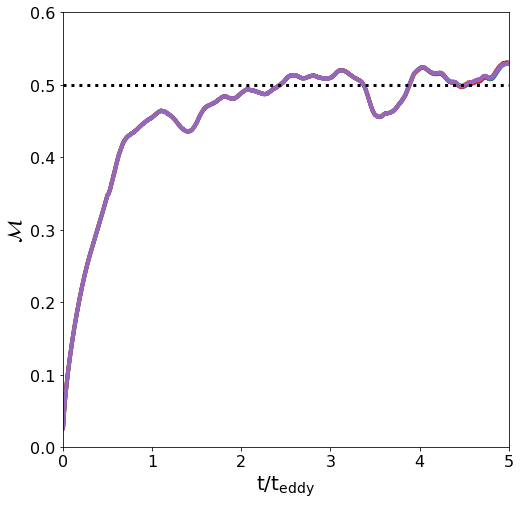

In [11]:
dir_name = "Turbulence"

res = 128

for i in range(len(ps.R_lsh)):
    file_name = f"{dir_name}/para_scan{ps.filename_turb_add(i,0)}/Turb.hst"
    hst = hst_data(file_name,res**3,True,False)

    cs = vt.cs_calc(ps.T_hot_req, ps.mu)

    plt.plot(hst.time/ps.t_eddy[i], hst.turb_vel/cs, linewidth=4)

plt.axhline(ps.M, linestyle='dotted', color='k', linewidth=3)

plt.xlim(0,5)
plt.ylim(0,0.6)

plt.ylabel(r"$\mathcal{M}$")
plt.xlabel(r't/t$_{\rm eddy}$')


Text(0.5, 0, 't/t$_{\\rm eddy}$')

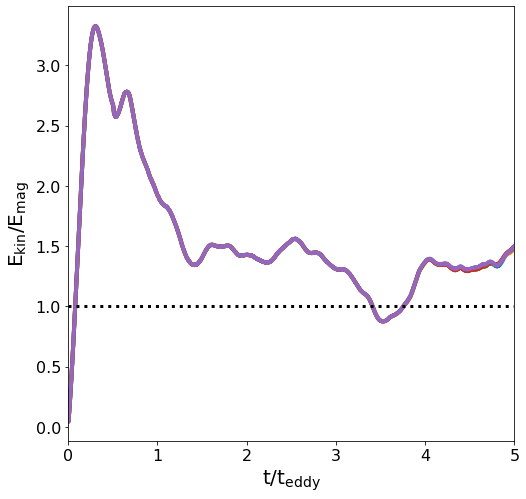

In [20]:
dir_name = "Turbulence"

res = 128

for i in range(len(ps.R_lsh)):
    file_name = f"{dir_name}/para_scan{ps.filename_turb_add(i,0)}/Turb.hst"
    hst = hst_data(file_name,res**3,True,False)

    plt.plot(hst.time/ps.t_eddy[i], hst.KE_tot/hst.mass_tot/hst.PB_avg, linewidth=4) #np.sqrt(2*hst.PB_avg))

plt.axhline(1.0, linestyle='dotted', color='k', linewidth=3)

plt.xlim(0,5)
# plt.ylim(0,0.6)

plt.ylabel(r"E$_{\rm kin}$/E$_{\rm mag}$")
plt.xlabel(r't/t$_{\rm eddy}$')


In [22]:
res = 128

file_name = f"para_scan_Rlsh2_500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst"
hst = hst_data(file_name,res**3,True,True)

plt.plot(hst.time/ps.t_eddy[i], hst.cold_gas)

# plt.axhline(ps.M)


ValueError: no field of name cold_gas

In [31]:
fn = "para_scan_Rlsh2_500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.out2.005.athdf"
# fn = "test2/Turb.out2.00010.athdf"

data = ar.athdf(fn)

T = (data['press']/data['rho'])*KELVIN*mu

In [46]:
cold_gas = []
time = []

for N in range(501,566):

    fn = f"para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.out2.00{N}.athdf"

    data = ar.athdf(fn)
    
    plt.figure()
    plt.imshow(np.average(data['rho'],axis=2,weights=data['rho']),vmin=1e0,vmax=1e2)
    # plt.imshow(np.log10(T[:,:,64]))
    
    plt.colorbar()

    plt.savefig(f"para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Plots/Slices/rho_{N}.png")
    plt.close()

    T = (data['press']/data['rho'])*KELVIN*mu

    cold_gas.append(np.sum(data['rho'][T<1.5*ps.T_cold]))
    time.append(N)



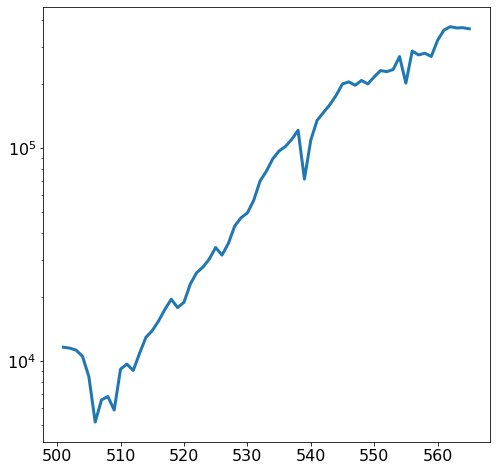

In [47]:

plt.figure()
plt.plot(time,cold_gas)

plt.yscale('log')

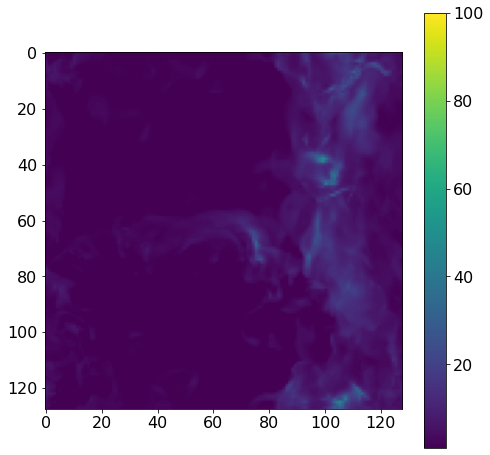

In [22]:

n  = 550
# fn = f"para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.out2.00{n}.athdf"
fn = f"para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_hydro/Turb.out2.00{n}.athdf"

data = ar.athdf(fn)
    
plt.figure()
plt.imshow(np.average(data['rho'],axis=2,weights=data['rho']),vmin=1e0,vmax=1e2)
# plt.imshow(data['rho'][:,:,64],vmin=1e0,vmax=1e2)
# plt.imshow(np.log10(T[:,:,64]))

T = (data['press']/data['rho'])*KELVIN*mu

plt.colorbar()

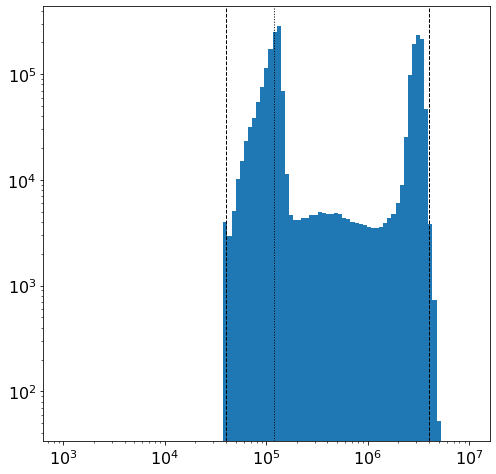

In [24]:
# bins_arr = np.logspace(-2,2,num=100)
bins_arr = np.logspace(3,7,num=100)

# plt.hist(np.ravel(data['rho']),bins=bins_arr)
plt.hist(np.ravel(T),bins=bins_arr,weights=np.ravel(data['rho']))

plt.xscale('log')
plt.yscale('log')

plt.axvline(4e4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(4e6, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.5*ps.T_cold, color='k', linestyle='dotted', linewidth=1)

# plt.axvline(1)
# plt.axvline(100)
